# Mini-BMN Notebook

Expand mini-BMN hamiltonian into Pauli strings

To Do
- add comments
- check units
- how to simulate? what to simulate?
- fuzzy spheres

In [40]:
import numpy as np
import sympy as sp
from collections import Counter
#from symengine.lib.symengine_wrapper import Zero as spZero
import symengine.lib.symengine_wrapper as symengine_wrapper
from typing import Union
from collections import Counter

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector, ParameterExpression
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import Pauli, Operator, SparsePauliOp, Statevector
from qiskit_algorithms import TimeEvolutionProblem, TrotterQRTE
from qiskit.primitives import Estimator
from qiskit.synthesis import SuzukiTrotter, LieTrotter
from qiskit_ibm_runtime import QiskitRuntimeService, Session

from qctrlresearchtools.ibm.platform import QCTRLPlatform

from bmn.sim_utils import SpecialUnitaryGroup, BMNModel

In [17]:
#FONTSIZE_LARGE = 10
#FONTSIZE_SMALL = 8

In [18]:
import matplotlib
import matplotlib.pyplot as plt
from cycler import cycler

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.size'] = 5.0
plt.rcParams['xtick.minor.size'] = 3.0
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rc('font', family='serif',size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=14)
plt.rcParams['ytick.minor.size'] = 3.0
matplotlib.rcParams.update({"axes.grid" : True,
                            "grid.alpha": 0.75,
                            "grid.linewidth": 0.5})
matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8'])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Trotter simulation of truncated mini-BMN model
- Note that if the truncation parameter `K=1`, then the Hamiltonian will be diagonal in the X-basis.

In [35]:
K = 2
Lambda = 2**K
N = 2 #N in SU(N)

bmn = BMNModel(gauge_group_degree=N, bits_per_oscillator=K)
num_qubits = bmn.num_qubits
nu = Parameter('nu')
H = bmn.hamiltonian(nu)
print(f"number of terms in Hamiltonian = {len(H)}")

number_qubits 18, Hilbert space dimension 262144
number of terms in Hamiltonian = 3013


In [36]:
pauli_str_lengths = [num_qubits - pauli.__str__().count('I') for pauli in H.paulis]
pauli_str_lengths = Counter(pauli_str_lengths)
pauli_str_lengths = dict(sorted(pauli_str_lengths.items()))
pauli_str_lengths

{0: 1, 1: 18, 2: 90, 3: 150, 4: 135, 5: 270, 6: 648, 7: 972, 8: 729}

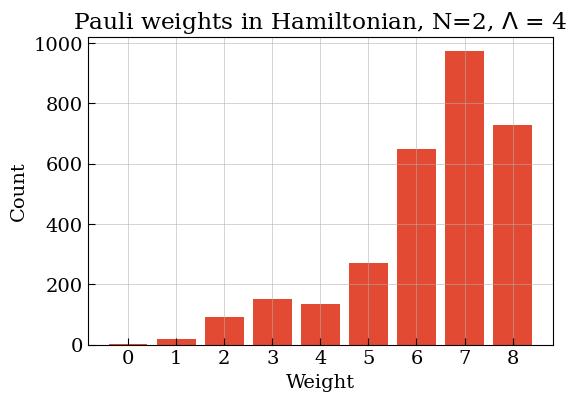

In [37]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.bar(pauli_str_lengths.keys(), pauli_str_lengths.values())
plt.xlabel('Weight')
plt.ylabel('Count')
plt.title(f'Pauli weights in Hamiltonian, N={N}, ' + r'$\Lambda$ = ' + str(Lambda))
ax.set_xticks(list(pauli_str_lengths.keys()))
plt.show()

In [38]:
final_time = 10
nu_value = 1.0
H_assigned = H.assign_parameters({nu: nu_value})

initial_state = Statevector.from_label("1" * num_qubits)
#initial_state = Statevector.from_label("010100110")

trotter = TrotterQRTE()
problem = TimeEvolutionProblem(H_assigned, initial_state=initial_state, time=final_time)
# this will crash if the number of qubits is too high
if num_qubits < 10:
    result = trotter.evolve(problem)
    statevector = Statevector(result.evolved_state)

num_timesteps = 20
product_formula = SuzukiTrotter(order=2, reps=1)
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator(), product_formula=product_formula)
problem = TimeEvolutionProblem(
    H_assigned,
    initial_state=initial_state,
    time=final_time,
    aux_operators=[H_assigned],
)
# this will crash if the number of qubits is too high
if num_qubits < 10:
    result = trotter.evolve(problem)

In [39]:
#product_formula = SuzukiTrotter(order=2, reps=1)
product_formula = LieTrotter(reps=1)
time = 1.0
evolution_instruction = PauliEvolutionGate(H_assigned, time, synthesis=product_formula)

qc = QuantumCircuit(num_qubits)
qc.append(evolution_instruction, [i for i in range(num_qubits)])
#qc.draw(output="mpl")

In [43]:
service_name = 'gavin-applications'
backend_name = "ibm_brisbane"

runtime_service = QiskitRuntimeService(name=service_name)
qctrl_platform = QCTRLPlatform(backend_name, runtime_service)

In [44]:
compiled_circs = qctrl_platform.transpile(
    circuits=qc,
    enable_dd=True,
    small_angle_threshold=0,
    )

/Users/gavinhartnett/miniforge3/envs/bmnsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/gavinhartnett/miniforge3/envs/bmnsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/gavinhartnett/miniforge3/envs/bmnsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/gavinhartnett/miniforge3/envs/bmnsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/gavinhartnett/miniforge3/envs/bmnsim/lib/python3.11/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/U

In [48]:
mat = np.asarray([
    [1, 2, 3],
    [4, 5, 6],
])
mat

array([[1, 2, 3],
       [4, 5, 6]])

In [49]:
mat[:, 0]

array([1, 4])

In [ ]:
observables = np.array(np.array(result.observables))
observables.shape

In [ ]:
observables[0]

NameError: name 'observables' is not defined

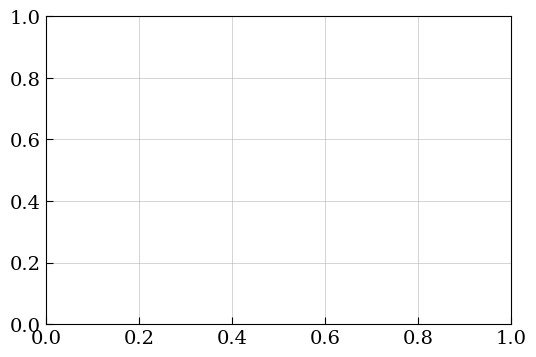

In [21]:
fig, ax = plt.subplots(figsize=(6, 4))
times = np.linspace(0, final_time, num_timesteps + 1)  # includes initial state
ax.plot(
    times, observables[:, 0], label="First order", marker="x", c="darkmagenta", ls="-", lw=0.8
)
ax.set_ylabel("Energy")
ax.set_ylabel("Magnetization")
ax.set_ylabel("Mean spin correlation")
ax.set_xlabel("Time")
fig.suptitle("Observable evolution")

In [ ]:
nu_values = np.linspace(0.1, 10, 10)
eigs = {}

for nu_value in nu_values:
    Hmat = bmn.hamiltonian(nu).assign_parameters({nu:nu_value}).to_matrix(sparse=False)

    # extract eigenvalues
    x = np.linalg.eigvals(Hmat)
    xR = np.real(x)
    xI = np.imag(x)
    # chop
    xR[np.isclose(xR, 0)] = 0
    xI[np.isclose(xI, 0)] = 0
    # verify eigenvalues are real
    assert np.array_equal(xI, np.zeros(len(xI)))

    eigs[nu_value] = xR

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(nu_values, [np.min(v) for v in eigs.values()], '-o')
plt.xlabel(r'$\nu$')
plt.ylabel(r'$E_0$')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
for i in range(2**bmn.num_qubits):
    ax.plot(nu_values, [np.sort(eigs[nu_value])[i] for nu_value in nu_values], '-o', color='k', linewidth=0.5)
ax.set_xlabel(r'$\nu$')
ax.set_ylabel(r'$E$')
#ax.set_yscale('log')
plt.show()

In [ ]:
from collections import Counter

for nu_value in nu_values:
    plt.hist(eigs[nu_value], bins=10, label=f'nu={nu_value:.02f}')
plt.legend()
plt.show()

In [ ]:
def maximum_weight_of_sparse_pauli(operator: SparsePauliOp) -> int:
    return max([bmn.num_qubits - p.__str__().count("I") for p in operator.paulis])

In [ ]:
# max pauli weight of creation operators
for matrix_idx in range(bmn.num_matrices):
    for generator_idx in range(bmn.num_matrices):
        print(maximum_weight_of_sparse_pauli(bmn.creation_operator(matrix_idx=matrix_idx, generator_idx=generator_idx)))